# Examples based on real world datasets

Table of Contents
1. [Faces recognition example using eigenfaces and SVMs](#Faces-recognition-example-using-eigenfaces-and-SVMs)
2. [Outlier detection on a real data set](#Outlier-detection-on-a-real-data-set)

## Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the “Labeled Faces in the Wild”, aka LFW: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

Download the data, if not already on disk and load it as numpy arrays

In [1]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Split into a training set and a test and keep 25% of the data for testing.

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.157s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s


Train a SVM classification model

Quantitative evaluation of the model quality on the test set

In [5]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 3.430s
Best estimator found by grid search:
SVC(C=np.float64(48076.586975319944), class_weight='balanced',
    gamma=np.float64(0.003662682851573851))


Predicting people's names on the test set
done in 0.040s
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.69      0.75        13
     Colin Powell       0.75      0.88      0.81        60
  Donald Rumsfeld       0.86      0.70      0.78        27
    George W Bush       0.88      0.96      0.92       146
Gerhard Schroeder       1.00      0.76      0.86        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.86       322
        macro avg       0.88      0.76      0.80       322
     weighted avg       0.86      0.86      0.85       322



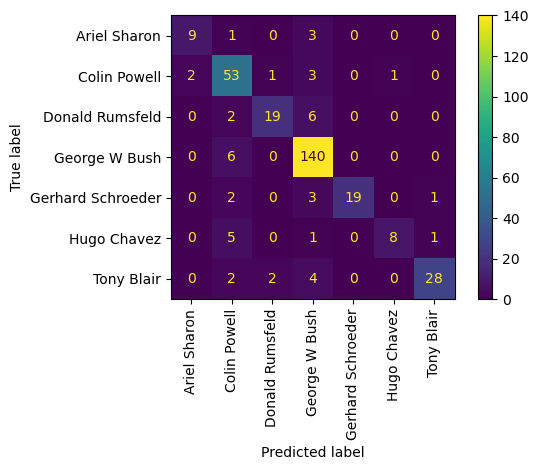

In [6]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Qualitative evaluation of the predictions using matplotlib

plot the result of the prediction on a portion of the test set

In [7]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

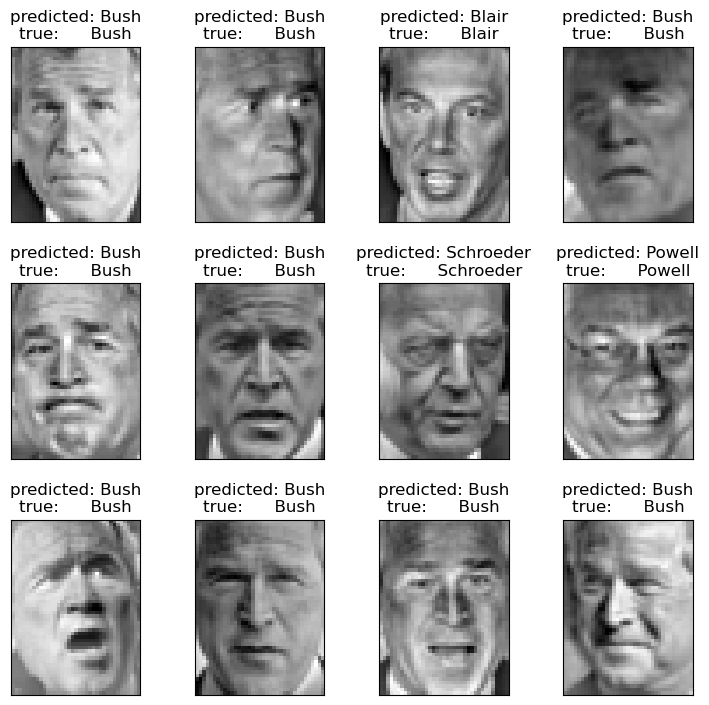

In [8]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

plot the gallery of the most significative eigenfaces

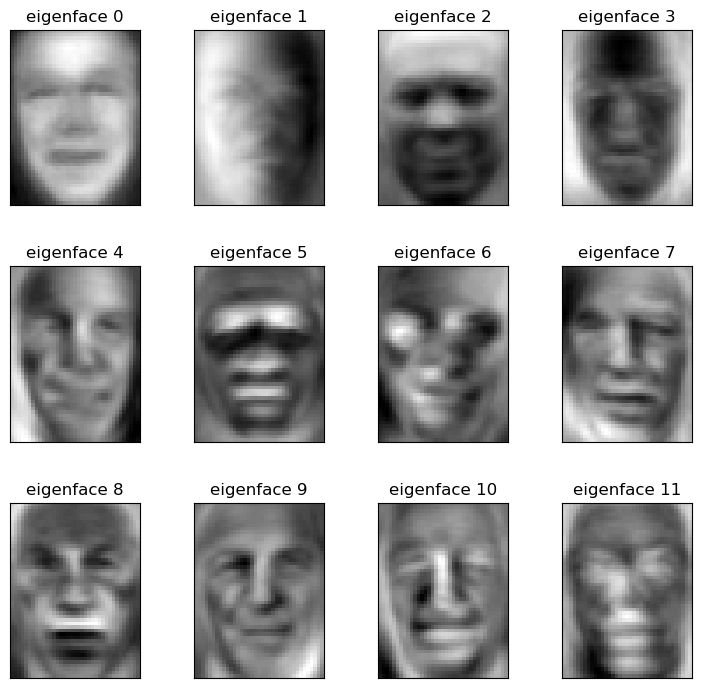

In [9]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

Face recognition problem would be much more effectively solved by training convolutional neural networks but this family of models is outside of the scope of the scikit-learn library. Interested readers should instead try to use pytorch or tensorflow to implement such models.

## Outlier detection on a real data set

This example illustrates the need for robust covariance estimation on a real data set. It is useful both for outlier detection and for a better understanding of the data structure.

We selected two sets of two variables from the Wine data set as an illustration of what kind of analysis can be done with several outlier detection tools. For the purpose of visualization, we are working with two-dimensional examples, but one should be aware that things are not so trivial in high-dimension, as it will be pointed out.

In both examples below, the main result is that the empirical covariance estimate, as a non-robust one, is highly influenced by the heterogeneous structure of the observations. Although the robust covariance estimate is able to focus on the main mode of the data distribution, it sticks to the assumption that the data should be Gaussian distributed, yielding some biased estimation of the data structure, but yet accurate to some extent. The One-Class SVM does not assume any parametric form of the data distribution and can therefore model the complex shape of the data much better.

### First example
The first example illustrates how the Minimum Covariance Determinant robust estimator can help concentrate on a relevant cluster when outlying points exist. Here the empirical covariance estimation is skewed by points outside of the main cluster. Of course, some screening tools would have pointed out the presence of two clusters (Support Vector Machines, Gaussian Mixture Models, univariate outlier detection, …). But had it been a high-dimensional example, none of these could be applied that easily.

In [10]:
from sklearn.covariance import EllipticEnvelope
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import OneClassSVM

estimators = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(
        contamination=0.25
    ),
    "OCSVM": OneClassSVM(nu=0.25, gamma=0.35),
}

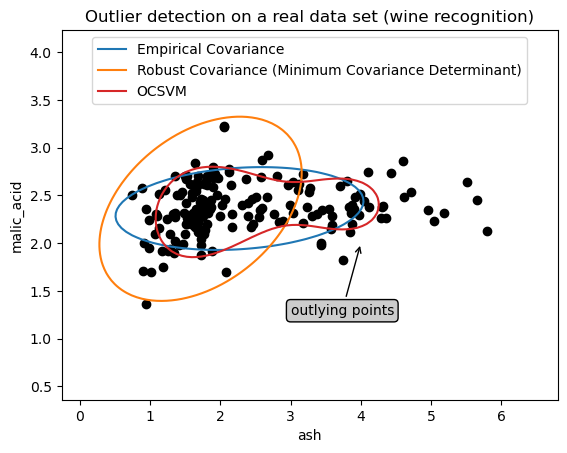

In [11]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

X = load_wine()["data"][:, [1, 2]]  # two clusters

fig, ax = plt.subplots()
colors = ["tab:blue", "tab:orange", "tab:red"]
# Learn a frontier for outlier detection with several classifiers
legend_lines = []
for color, (name, estimator) in zip(colors, estimators.items()):
    estimator.fit(X)
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="decision_function",
        plot_method="contour",
        levels=[0],
        colors=color,
        ax=ax,
    )
    legend_lines.append(mlines.Line2D([], [], color=color, label=name))


ax.scatter(X[:, 0], X[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
ax.annotate(
    "outlying points",
    xy=(4, 2),
    xycoords="data",
    textcoords="data",
    xytext=(3, 1.25),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
ax.legend(handles=legend_lines, loc="upper center")
_ = ax.set(
    xlabel="ash",
    ylabel="malic_acid",
    title="Outlier detection on a real data set (wine recognition)",
)

### Second example
The second example shows the ability of the Minimum Covariance Determinant robust estimator of covariance to concentrate on the main mode of the data distribution: the location seems to be well estimated, although the covariance is hard to estimate due to the banana-shaped distribution. Anyway, we can get rid of some outlying observations. The One-Class SVM is able to capture the real data structure, but the difficulty is to adjust its kernel bandwidth parameter so as to obtain a good compromise between the shape of the data scatter matrix and the risk of over-fitting the data.

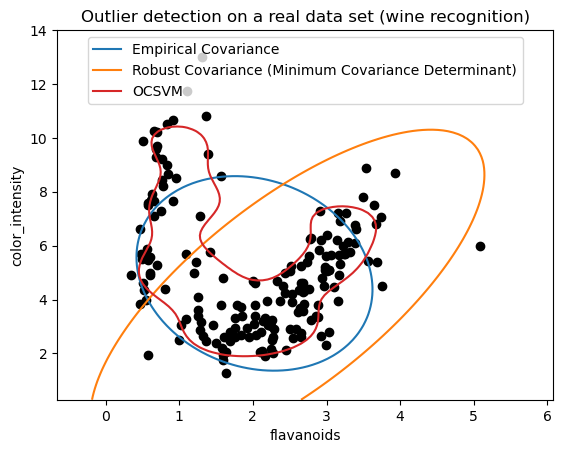

In [12]:
X = load_wine()["data"][:, [6, 9]]  # "banana"-shaped

fig, ax = plt.subplots()
colors = ["tab:blue", "tab:orange", "tab:red"]
# Learn a frontier for outlier detection with several classifiers
legend_lines = []
for color, (name, estimator) in zip(colors, estimators.items()):
    estimator.fit(X)
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="decision_function",
        plot_method="contour",
        levels=[0],
        colors=color,
        ax=ax,
    )
    legend_lines.append(mlines.Line2D([], [], color=color, label=name))


ax.scatter(X[:, 0], X[:, 1], color="black")
ax.legend(handles=legend_lines, loc="upper center")
ax.set(
    xlabel="flavanoids",
    ylabel="color_intensity",
    title="Outlier detection on a real data set (wine recognition)",
)

plt.show()

## Visualizing the stock market structure

This example employs several unsupervised learning techniques to extract the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes that are linked tend to fluctuate in relation to each other during a day.

### Retrieve the data from Internet
The data is from 2003 - 2008. This is reasonably calm: not too long ago so that we get high-tech firms, and before the 2008 crash. This kind of historical data can be obtained from APIs like the [data.nasdaq.com](https://data.nasdaq.com/) and [alphavantage.co.](https://www.alphavantage.co/)

In [13]:
import sys

import numpy as np
import pandas as pd

symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print("Fetching quote history for %r" % symbol, file=sys.stderr)
    url = (
        "https://raw.githubusercontent.com/scikit-learn/examples-data/"
        "master/financial-data/{}.csv"
    )
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q["close"] for q in quotes])
open_prices = np.vstack([q["open"] for q in quotes])

# The daily variations of the quotes are what carry the most information
variation = close_prices - open_prices

Fetching quote history for np.str_('AAPL')
Fetching quote history for np.str_('AIG')
Fetching quote history for np.str_('AMZN')
Fetching quote history for np.str_('AXP')
Fetching quote history for np.str_('BA')
Fetching quote history for np.str_('BAC')
Fetching quote history for np.str_('CAJ')
Fetching quote history for np.str_('CAT')
Fetching quote history for np.str_('CL')
Fetching quote history for np.str_('CMCSA')
Fetching quote history for np.str_('COP')
Fetching quote history for np.str_('CSCO')
Fetching quote history for np.str_('CVC')
Fetching quote history for np.str_('CVS')
Fetching quote history for np.str_('CVX')
Fetching quote history for np.str_('DD')
Fetching quote history for np.str_('DELL')
Fetching quote history for np.str_('F')
Fetching quote history for np.str_('GD')
Fetching quote history for np.str_('GE')
Fetching quote history for np.str_('GS')
Fetching quote history for np.str_('GSK')
Fetching quote history for np.str_('HD')
Fetching quote history for np.str_('H

### Learning a graph structure
We use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others. Specifically, sparse inverse covariance gives us a graph, that is a list of connections. For each symbol, the symbols that it is connected to are those useful to explain its fluctuations.



In [14]:
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

### Clustering using affinity propagation
We use clustering to group together quotes that behave similarly. Here, amongst the various clustering techniques available in the scikit-learn, we use Affinity Propagation as it does not enforce equal-size clusters, and it can choose automatically the number of clusters from the data.

Note that this gives us a different indication than the graph, as the graph reflects conditional relations between variables, while the clustering reflects marginal properties: variables clustered together can be considered as having a similar impact at the level of the full stock market.

In [15]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, McDonald's, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 8: Kellogg, Coca Cola, Pepsi
Cluster 9: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 10: Canon, Honda, Navistar, Sony, Toyota, Xerox


### Embedding in 2D space
For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this, we use Manifold learning techniques to retrieve 2D embedding. We use a dense eigen_solver to achieve reproducibility (arpack is initiated with the random vectors that we do not control). In addition, we use a large number of neighbors to capture the large-scale structure.

In [16]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

### Visualization
The output of the 3 models are combined in a 2D graph where nodes represent the stocks and edges the connections (partial correlations):

cluster labels are used to define the color of the nodes

the sparse covariance model is used to display the strength of the edges

the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as visualization is crucial here to display the graph. One of the challenges is to position the labels minimizing overlap. For this, we use an heuristic based on the direction of the nearest neighbor along each axis.

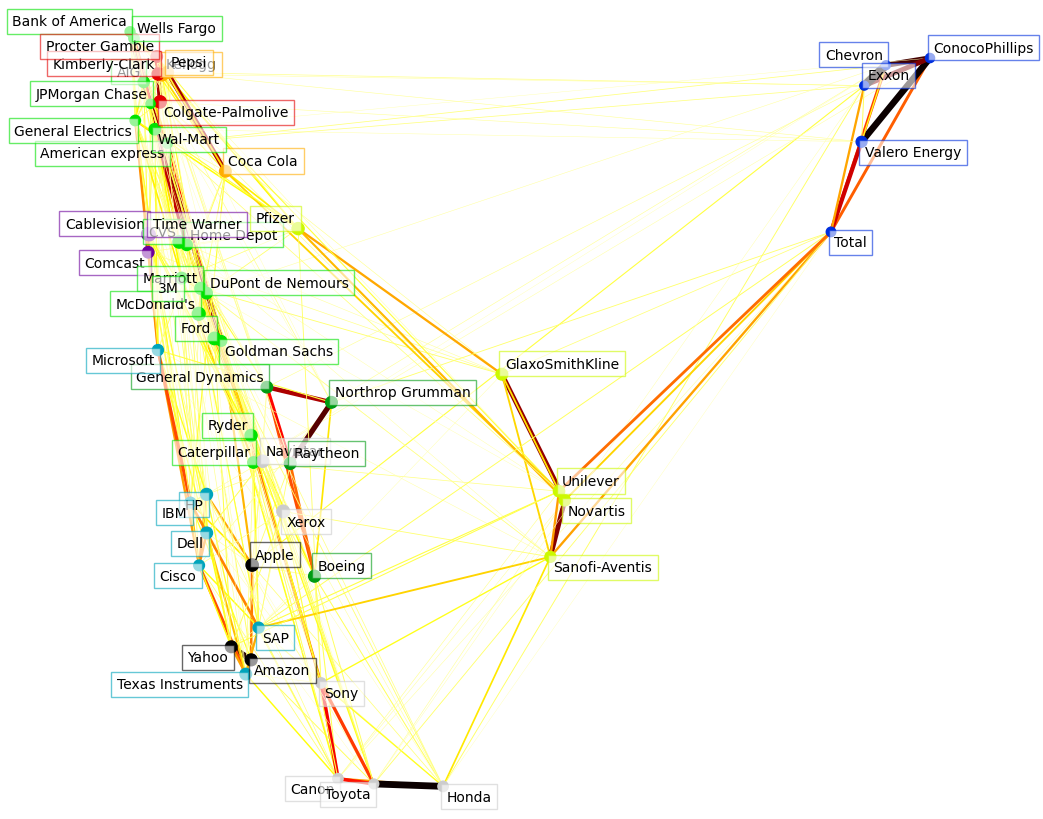

In [17]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = non_zero.nonzero()
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()